In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad

In [ ]:
sc._settings.ScanpyConfig.n_jobs = 8

In [5]:
def z_score_normalization(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

def reorder_columns(df, col_changed, col_position) -> pd.DataFrame:
    """
    Reordering colums. The second input can either be an integer for index or it can be a reference column name. If reference column name is chosen, the column will be placed after the reference column.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The first argument must be a pandas DataFrame")
    if not isinstance(col_changed, str):
        raise ValueError("The second argument must be a string representing a column name")
    if not isinstance(col_position, (str, int)):
        raise ValueError("The third argument must be either a string representing a column name or an integer representing a column index")
    if isinstance(col_position, int):
        cols = df.columns.tolist()
        if col_changed in cols and col_position <= len(cols) + 1:
            cols.remove(col_changed)
        
            index = col_position
            cols.insert(index, col_changed)
            
            df = df[cols]
    else:
        cols = df.columns.tolist()
        if col_changed in cols and col_position in cols:
            cols.remove(col_changed)
            index = cols.index(col_position)
            cols.insert(index+1, col_changed)
            
            df = df[cols]
    return df

In [2]:
df = pd.read_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets2/IMMUcan/quantification/IMMUcan_combined.csv', index_col=0)

In [ ]:
df.columns

In [ ]:
df.cell_labels.value_counts()

In [ ]:
df.columns

In [3]:
df.drop(columns=['acquisition_id', 'Study', 'SlideId', 'Box.Description', 'Position', 'Indication', 'ROI', 'ROIonSlide', 'includeImage',
                 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'SubBatchId', 'SampleId',
                 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch'], inplace=True) 
df.rename(columns={'celltypes': 'cell_type', 'Pos_X': 'x', 'Pos_Y': 'y'}, inplace=True)

In [6]:
df = reorder_columns(df, 'cell_type', 'cell_labels')

In [ ]:
df['BatchId'].nunique()

In [ ]:
df.to_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets2/IMMUcan/quantification/processed/IMMUcan_quantification.csv', index=False)

In [ ]:
df[['image']].nunique()

In [7]:
X_columns = df.columns[:df.columns.get_loc('image')]
obs_columns =df.columns[df.columns.get_loc('image'):]
adata = ad.AnnData(
    X=df[X_columns],
    obs=df[obs_columns],
    var=pd.DataFrame(index=X_columns)
)

In [ ]:

adata.raw = adata.copy()
#adata.X = np.arcsinh(adata.X/1)
adata.layers['zscore'] = z_score_normalization(adata.X)
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')


In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color='cell_type')

In [ ]:
sc.pl.umap(adata, color='BatchId')

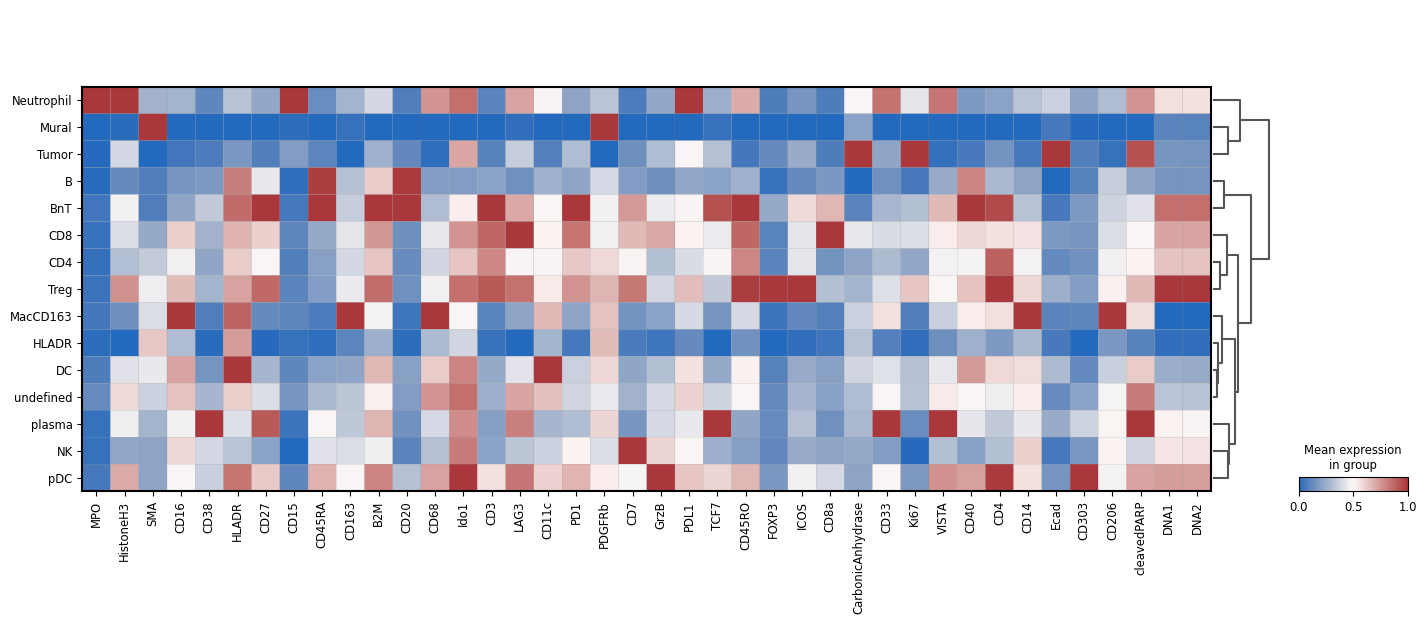

In [8]:
sc.pl.matrixplot(adata, var_names=adata.var_names, groupby='cell_type', cmap='vlag', dendrogram=True, use_raw=False,
                 standard_scale='var'
                 )

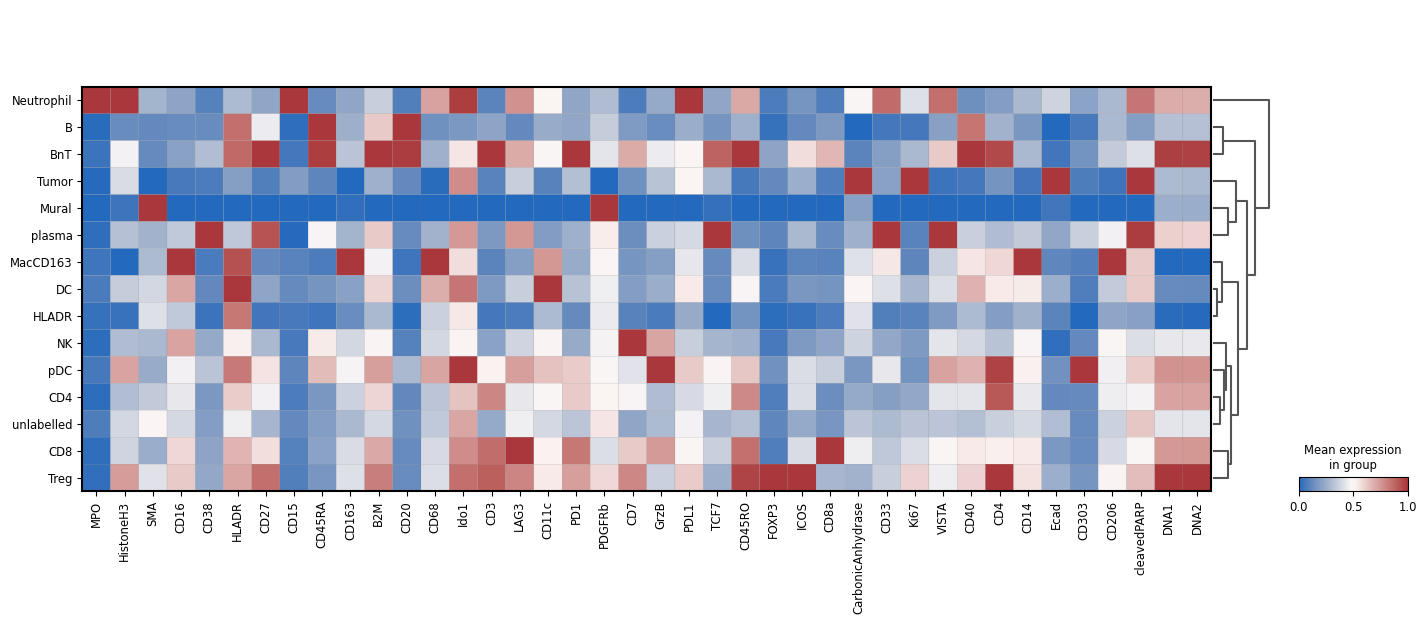

In [9]:
sc.pl.matrixplot(adata, var_names=adata.var_names, groupby='cell_labels', cmap='vlag', dendrogram=True, use_raw=False,
                 standard_scale='var'
                 )

In [ ]:
sc.pp.combat(adata, key='sample_id')

In [ ]:
df = adata.to_df()
for col in adata.obs.columns:
    df[col] = adata.obs[col]

In [ ]:
df

In [ ]:
adata.X

In [ ]:
df.to_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets2/IMMUcan/quantification/processed/IMMUcan_quantification_combat.csv', index=False)

# Harmonize celltype labels

In [ ]:
df = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/IMMUcan_quantification.csv')


In [ ]:
df.columns

In [ ]:
df['cell_type'] = df['cell_type'].replace({'Tumor' : 'Cancer', 'Mural':'Stroma', 'CD8':'CD8+_T_cell', 'MacCD163':'M2_Macrophage',
                                           'CD4':'CD4+_T_cell', 'plasma':'Plasma_cell','DC':'Dendritic_cell', 'B':'B_cell',
                                           'NK':'NK_cell', 'pDC':'Plasmacytoid_dendritic_cell'})
df['cell_labels'] = df['cell_labels'].replace({'Tumor' : 'Cancer', 'Mural':'Stroma', 'CD8':'CD8+_T_cell', 'MacCD163':'M2_Macrophage',
                                             'CD4':'CD4+_T_cell', 'plasma':'Plasma_cell','DC':'Dendritic_cell', 'B':'B_cell',
                                                'NK':'NK_cell', 'pDC':'Plasmacytoid_dendritic_cell'})
df['cell_type'].value_counts()

In [ ]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/IMMUcan_quantification.csv', index=False)

# Implement different levels of granularity

In [10]:
df = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/IMMUcan_quantification.csv')
df['cell_type'].value_counts()

cell_type
Cancer                         210853
Stroma                          50127
CD8+_T_cell                     35867
M2_Macrophage                   33882
CD4+_T_cell                     25832
Plasma_cell                     17972
HLADR                           14793
Neutrophil                      14723
BnT                             13497
Treg                            10809
Dendritic_cell                  10098
B_cell                           8263
undefined                        4074
NK_cell                          3412
Plasmacytoid_dendritic_cell      2915
Name: count, dtype: int64

In [11]:
df.dtypes

MPO                  float64
HistoneH3            float64
SMA                  float64
CD16                 float64
CD38                 float64
HLADR                float64
CD27                 float64
CD15                 float64
CD45RA               float64
CD163                float64
B2M                  float64
CD20                 float64
CD68                 float64
Ido1                 float64
CD3                  float64
LAG3                 float64
CD11c                float64
PD1                  float64
PDGFRb               float64
CD7                  float64
GrzB                 float64
PDL1                 float64
TCF7                 float64
CD45RO               float64
FOXP3                float64
ICOS                 float64
CD8a                 float64
CarbonicAnhydrase    float64
CD33                 float64
Ki67                 float64
VISTA                float64
CD40                 float64
CD4                  float64
CD14                 float64
Ecad          

In [ ]:
df.columns

In [ ]:
df['level_2_cell_type'] = df['cell_type']
df['level_2_cell_type'] = df['level_2_cell_type'].replace({'CD8+_T_cell':'Lymphoid_immune', 'M2_Macrophage':'Myeloid_immune', 'CD4+_T_cell':'Lymphoid_immune', 'Plasma_cell':'Lymphoid_immune',
                                                           'Neutrophil':'Myeloid_immune', 'BnT':'Lymphoid_immune', 'Treg':'Lymphoid_immune', 'Dendritic_cell':'Myeloid_immune', 'B_cell':'Lymphoid_immune',
                                                           'NK_cell':'Lymphoid_immune', 'Plasmacytoid_dendritic_cell':'Myeloid_immune'})
df['level_2_cell_type'].value_counts()

In [ ]:
df['level_1_cell_type'] = df['level_2_cell_type']
df['level_1_cell_type'] = df['level_1_cell_type'].replace({'Lymphoid_immune':'Immune', 'Myeloid_immune':'Immune', 'Stroma':'Stromal'})
df['level_1_cell_type'].value_counts()

In [ ]:
df = reorder_columns(df, 'cell_type', 'level_1_cell_type')
df = reorder_columns(df, 'level_2_cell_type', 'level_1_cell_type')
df 

In [ ]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/IMMUcan_quantification.csv', index=False)

# Encode uninfomrative variables with different dtypes

In [3]:
df = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/IMMUcan_quantification.csv')
df.columns

Index(['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
       'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
       'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
       'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
       'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
       'DNA2', 'image', 'sample_id', 'ObjectNumber', 'x', 'y', 'area',
       'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px',
       'height_px', 'cell_labels', 'level_1_cell_type', 'level_2_cell_type',
       'cell_type'],
      dtype='object')

In [6]:
df.dtypes

MPO                  float64
HistoneH3            float64
SMA                  float64
CD16                 float64
CD38                 float64
HLADR                float64
CD27                 float64
CD15                 float64
CD45RA               float64
CD163                float64
B2M                  float64
CD20                 float64
CD68                 float64
Ido1                 float64
CD3                  float64
LAG3                 float64
CD11c                float64
PD1                  float64
PDGFRb               float64
CD7                  float64
GrzB                 float64
PDL1                 float64
TCF7                 float64
CD45RO               float64
FOXP3                float64
ICOS                 float64
CD8a                 float64
CarbonicAnhydrase    float64
CD33                 float64
Ki67                 float64
VISTA                float64
CD40                 float64
CD4                  float64
CD14                 float64
Ecad          

In [5]:
df = df.rename(columns={'ObjectNumber': 'cell_id'})

In [7]:
df.to_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/IMMUcan_quantification.csv', index=False)